# Context Plots
Plots show ALHIC1901 228_4 and 230_4 data in the context of other core data, and relative to each other.

## Import Packages

In [92]:
# general
import numpy as np
from tqdm import tqdm
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib



## Setup

In [93]:
# Set filepaths

path_to_data = '../../data/'
path_to_samples = '../../data/sampling/master/'
path_to_angles = '../../data/angles/'
path_to_figures = '../../../figures/'

## Load data

In [94]:
# load sample data
samps = ['water_iso','cc','ic_icpms','cfa','ghg','ecm_median']

# loop through and load all sample files
for s in samps:

    if s == samps[0]:
        samp_data = pd.read_csv(path_to_samples + s+'_master.csv')

    else:

        df = pd.read_csv(path_to_samples + s+'_master.csv')
        samp_data = pd.concat([samp_data, df], ignore_index=True)

samp_data.head()

,section,stick,top_depth,bottom_depth,mid_depth,dD,d17O,d18O,dxs,x_lo,...,co2,ch4,tac,AC_ecm,xlo,xhi,ylo,yhi,core,DC_ecm
0,228_4,l_iso,155.0650,155.0750,155.0700,-296.18,-19.70,-37.03,0.07,-0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,228_4,l_iso,155.0761,155.0861,155.0811,-295.74,-19.69,-36.96,-0.05,-0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,228_4,l_iso,155.0873,155.0973,155.0923,-295.99,-19.72,-37.05,0.40,-0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,228_4,l_iso,155.0984,155.1084,155.1034,-296.24,-19.80,-37.22,1.49,-0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,228_4,l_iso,155.1095,155.1195,155.1145,-296.55,-19.90,-37.40,2.62,-0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
# load context data
context_data = pd.read_csv(path_to_data + 'broader_context/broader_context_clean.csv')

In [96]:
# load unit data
units = pd.read_excel(path_to_data+'sampling/units.xlsx')

## Define Functions

In [97]:
def common_interval(data,prox1,prox2):
    """
    Function to get two different datasets onto a common depth scale

    Parameters
    ----------
    samp_data : pandas.DataFrame
        Dataframe containing the data to be compared
    prox1 : str
        Column name of the first dataset. We will use this as the target depth frame
    prox2 : str
        Column name of the second dataset
    
    Returns
    -------
    df  : pandas.DataFrame
        Dataframe containing the common depth scale and the values of the two datasets
    """

    # get subset of dataframe where the prox1 column is not nan
    p1_data = data[samp_data[prox1].notna()]
    p2_data = data[samp_data[prox2].notna()]

    # make finiely (1 mm) spaced depth scale
    d_min = min(p1_data['top_depth_adj'].min(), p2_data['top_depth_adj'].min())
    d_max = max(p1_data['bottom_depth_adj'].max(), p2_data['bottom_depth_adj'].max())
    d_common = np.arange(np.round(d_min,3), np.round(d_max,3), 0.001)

    # interpolate both datasets onto finely spaced common depth vector
    p1_val = []
    p2_val = []
    for d in d_common:

        # find row in p2_data where the top depth is less than the common depth and bottom depth is greater than the common depth
        p2_row = p2_data[(p2_data['top_depth_adj'] <= d) & (p2_data['bottom_depth_adj'] >= d)]

        # if there is a row in p2_data, get the values and add to the common dataframe
        if len(p2_row) > 0:

            # get the values from the row
            p2_val.append(p2_row[prox2].values[0])
        else:
            p2_val.append(np.nan)

    # now caluclate the average value of p1_data between 'top_depth_adj' and 'bottom_depth_adj' in p2_data
    new_p2_val = []
    for index, row in p1_data.iterrows():

        #idx = np.where((d_common >= row['top_depth_adj']) & (d_common <= row['bottom_depth_adj']))

        idx1 = d_common >= row['top_depth_adj']
        idx2 = d_common <= row['bottom_depth_adj']
        idx = np.logical_and(idx1, idx2)

        p2 = np.array(p2_val)[idx]

        new_p2_val.append(np.nanmean(p2))
        
    # now add the new p2_val to the p1_data dataframe
    p1_data[prox2] = new_p2_val

    # now only keep the important columns of the dataframe
    col = ['section','stick','top_depth_adj','bottom_depth_adj','mid_depth_adj',prox1,prox2]
    p1_data = p1_data[col]
        
    return p1_data


In [98]:
def plot_scatter(data,prox1,prox2,units,flipx=False):
    """
    Function to plot a scatter plot of two different datasets
    Parameters
    ----------
    data : pandas.DataFrame
        Dataframe containing the data to be compared
    prox1 : str
        Column name of the first dataset. We will use this as the target depth frame
    prox2 : str
        Column name of the second dataset
    flipx : bool
        If True, make prox2 the x axis and prox1 the y axis

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object containing the scatter plot
    ax : matplotlib.axes._axes.Axes
        Axes object containing the scatter plot
    """

    # get the common depth scale for the two datasets
    if prox1  in data.columns and prox2  in data.columns:
        df = common_interval(data,prox1,prox2)

    # flip axis for plotting now that we've put on a common depth scale
    
    if flipx == True:
        prox1, prox2 = prox2, prox1

    # Define colors for each section
    section_colors = {'228_4': 'black', '230_4': 'green'}
    section_shapes = {
        '228_4': '^',
        '230_4': 's'
    }

    # make figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # plot the 228_4 and 230_4 data
    if prox1  in data.columns and prox2  in data.columns:

        for section in df['section'].unique():

            section_df = df[df['section'] == section]
            
            ax.plot(
                section_df[prox1],
                section_df[prox2],
                color=section_colors[section],
                marker=section_shapes[section],
                markersize=7,
                linestyle='None',
                label=section
            )
            
    # look up fancy name and units
    unit_row = units.loc[units['simple_name'] == prox1]
    if len(unit_row) == 1:
        x_full_name = unit_row.latex_name.iloc[0]
        x_unit = unit_row.units.iloc[0]
    else:
        x_full_name = prox1
        x_unit = ''
    unit_row = units.loc[units['simple_name'] == prox2]
    if len(unit_row) == 1:
        y_full_name = unit_row.latex_name.iloc[0]
        y_unit = unit_row.units.iloc[0]
    else:
        y_full_name = prox2
        y_unit = ''

    ax.set_xlabel(x_full_name + ' (' + x_unit + ')')
    ax.set_ylabel(y_full_name + '(' + y_unit + ')')
    ax.set_title(x_full_name + ' and '+y_full_name)

    # add a legend
    ax.legend(loc='upper left', fontsize=12, markerscale=0.7)

    return fig, ax

In [ ]:
def plot_scatter_withbroader(data,prox1,prox2,units,broader_context,flipx=False):
    """
    Function to plot a scatter plot of two different datasets
    Parameters
    ----------
    data : pandas.DataFrame
        Dataframe containing the data to be compared
    prox1 : str
        Column name of the first dataset. We will use this as the target depth frame
    prox2 : str
        Column name of the second dataset
    flipx : bool
        If True, make prox2 the x axis and prox1 the y axis
    broader_context : pandas.DataFrame
        Dataframe containing the broader context data. If None, do not plot the broader context data
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object containing the scatter plot
    ax : matplotlib.axes._axes.Axes
        Axes object containing the scatter plot
    """

    # get the common depth scale for the two datasets
    if prox1  in data.columns and prox2  in data.columns:
        df = common_interval(data,prox1,prox2)

    # flip axis for plotting now that we've put on a common depth scale
    
    if flipx == True:
        prox1, prox2 = prox2, prox1

    # Define colors for each section
    section_colors = {'228_4': 'black', '230_4': 'green'}
    section_shapes = {
        '228_4': '^',
        '230_4': 's'
    }

    # make figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # plot the broader context data 
    ax.scatter(
        broader_context[prox1],
        broader_context[prox2],
        c=broader_context['top_depth'],
        cmap='RdBu',
        alpha=0.5,
        label='Published Data',
        s=18
    )

    # Add a colorbar for the depth from the broader context data
    norm = plt.Normalize(130, 160)
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Depth (m)')

    # # plot the broader context data
    # for index, row in broader_context.iterrows():
    #     if index == broader_context.index[0]:
    #         label = 'Broader Context'
    #     else:
    #         label = ''
    #     ax.plot(
    #         row[prox1],
    #         row[prox2],
    #         color = sm.to_rgba(row['top_depth'],alpha=None),  # No alpha specified, just RGB
    #         alpha=0.8,
    #         marker = 'o',
    #         markersize=4,
    #         linestyle='None',
    #         label = label
    #     )

    # plot the 228_4 and 230_4 data
    if prox1  in data.columns and prox2  in data.columns:

        for section in df['section'].unique():

            section_df = df[df['section'] == section]

            # for index, row in section_df.iterrows():

            #     if index == section_df.index[0]:
            #         label = section
            #     else:
            #         label = ''

            #     ax.plot(
            #         row[prox1],
            #         row[prox2],
            #         color=sm.to_rgba(row['mid_depth_adj'], alpha=None),  # No alpha specified, just RGB
            #         marker=section_shapes[section],
            #         markersize=7,
            #         linestyle='None',
            #         label=label
            #     )


            ax.plot(
                section_df[prox1],
                section_df[prox2],
                color=section_colors[section],
                #color=sm.to_rgba(section_df['mid_depth_adj']),
                marker=section_shapes[section],
                markersize=7,
                linestyle='None',
                label=section
            )

    # look up fancy name and units
    unit_row = units.loc[units['simple_name'] == prox1]
    if len(unit_row) == 1:
        x_full_name = unit_row.latex_name.iloc[0]
        x_unit = unit_row.units.iloc[0]
    else:
        x_full_name = prox1
        x_unit = ''
    unit_row = units.loc[units['simple_name'] == prox2]
    if len(unit_row) == 1:
        y_full_name = unit_row.latex_name.iloc[0]
        y_unit = unit_row.units.iloc[0]
    else:
        y_full_name = prox2
        y_unit = ''

    ax.set_xlabel(x_full_name + ' (' + x_unit + ')')
    ax.set_ylabel(y_full_name + '(' + y_unit + ')')
    ax.set_title(x_full_name + ' and '+y_full_name)

    # add a legend
    ax.legend(loc='upper left', fontsize=8, markerscale=1.1, framealpha=0.8, 
            fancybox=True, shadow=True)

    return fig, ax

## Make Plots

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_11855/1556455338.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p1_data[prox2] = new_p2_val


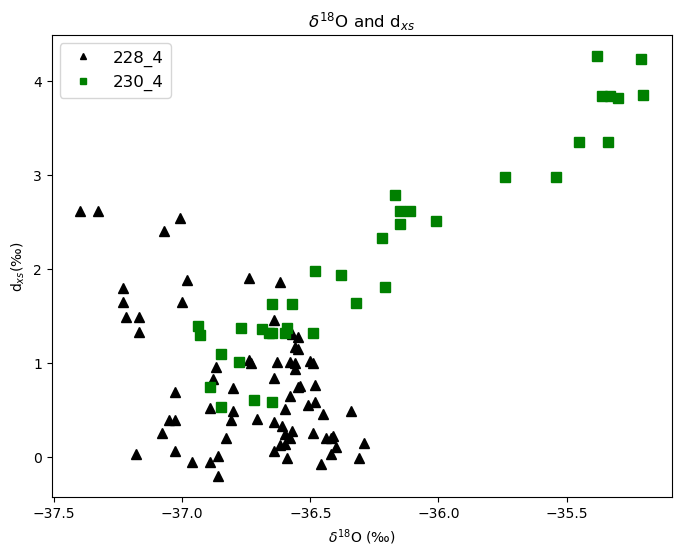

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_11855/1556455338.py:57: RuntimeWarning: Mean of empty slice
  new_p2_val.append(np.nanmean(p2))
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_11855/1556455338.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p1_data[prox2] = new_p2_val


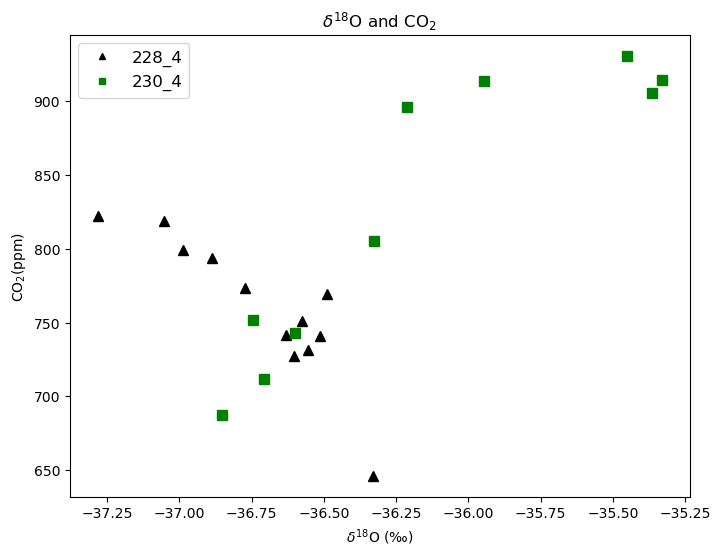

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_11855/1556455338.py:57: RuntimeWarning: Mean of empty slice
  new_p2_val.append(np.nanmean(p2))
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_11855/1556455338.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p1_data[prox2] = new_p2_val


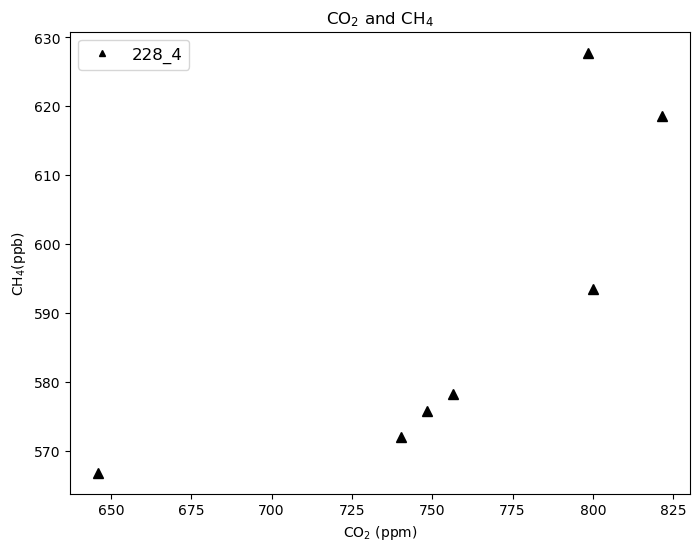

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_11855/1556455338.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p1_data[prox2] = new_p2_val


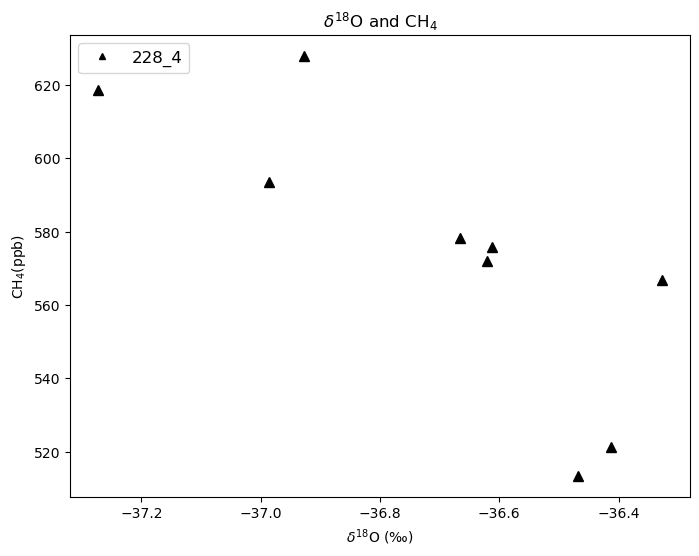

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_11855/1556455338.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p1_data[prox2] = new_p2_val


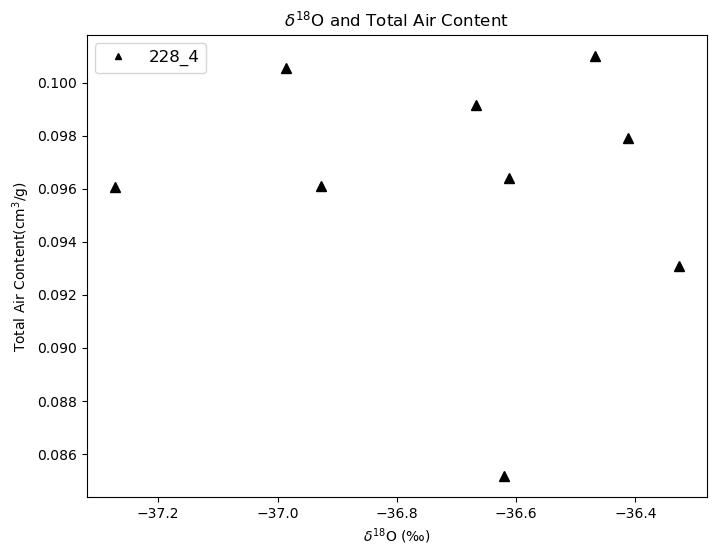

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


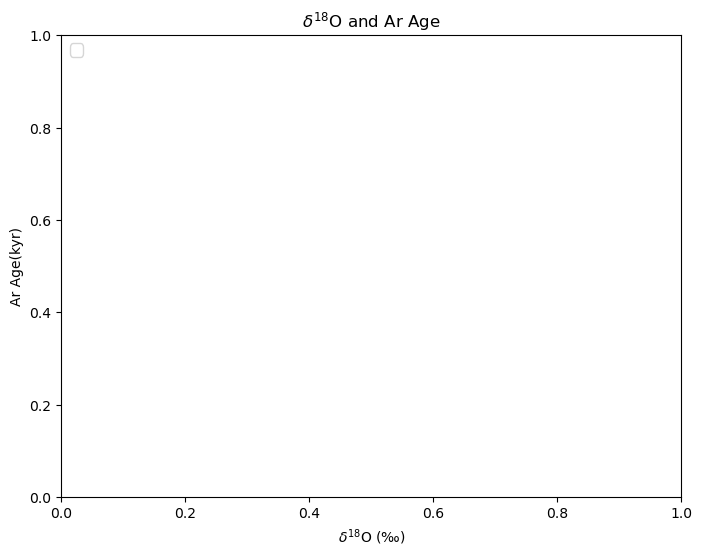

In [103]:
combos = [
    ['d18O','dxs',False],
    ['co2','d18O',True],
    ['ch4','co2',True],
    ['ch4','d18O',True],
    ['tac','d18O',True],
    ['age','d18O',True],
]

for c in combos:
    fig, ax = plot_scatter(samp_data,c[0],c[1],units,flipx=c[2])
    plt.show()
    fig.savefig(path_to_figures+'scatter/'+c[0]+'_'+c[1]+'.png', dpi=300)
    plt.close(fig)

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_11855/1556455338.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p1_data[prox2] = new_p2_val
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_11855/2964863397.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


NameError: name 'section_colors' is not defined

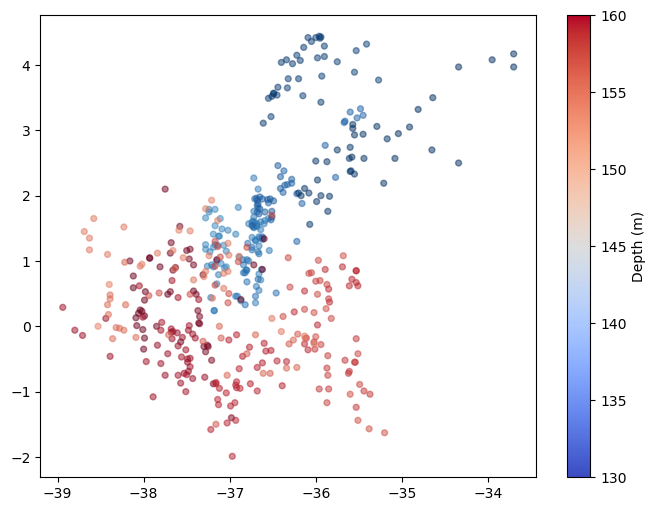

In [104]:
# Same plots - now with broader context data

# combos = [
#     ['d18O','dxs',False],
#     ['co2','d18O',True],
#     ['ch4','co2',True],
#     ['ch4','d18O',True],
#     ['tac','d18O',True],
#     ['age','d18O',True],
# ]

for c in combos:
    fig, ax = plot_scatter_withbroader(samp_data,c[0],c[1],units,context_data,flipx=c[2])
    plt.show()
    fig.savefig(path_to_figures+'scatter/'+c[0]+'_'+c[1]+'.png', dpi=300)
    plt.close(fig)

## Plot with Depth

In [ ]:
prox = ['age','co2','ch4','tac','concentration','d18O','dxs']
fig, ax = plt.subplots(1,len(prox),figsize=(2.5*len(prox), 8))

# make a list of attractive colors for the lines using a colormap
cmap = plt.get_cmap('tab10')

# plot each proxy - context data
for i, p in enumerate(prox):

    # filter for rows of df where the p column is not nan
    p_data = context_data[context_data[p].notna()]

    # order by depth
    p_data = p_data.sort_values(by='top_depth', ascending=False)

    # plot the data
    ax[i].plot(p_data[p], p_data['top_depth'], '.', color=cmap(i), alpha=0.3, label='Published Data',markersize=8)
    ax[i].plot(p_data[p], p_data['top_depth'], '-', color=cmap(i), alpha=0.2, linewidth=1, label='')

# plot each proxy - project data
secs = ['228_4','230_4']
for i, p in enumerate(prox):

    # check if p is a column in samp_data
    if p in samp_data.columns:

        # filter for rows of df where the p column is not nan
        p_data = samp_data[samp_data[p].notna()]

        # order by depth
        p_data = p_data.sort_values(by='top_depth_adj', ascending=False)

        # plot the data
        for sec,shape in zip(secs,['s','^']):

            sec_data = p_data[p_data['section'] == sec]

            ax[i].plot(sec_data[p], sec_data['top_depth_adj'], shape, color=cmap(i), linewidth=0.5, label='Section: '+sec, markerfacecolor='none',markersize=10)

# if prox is 'concentration', make the x axis log scale
for i, p in enumerate(prox):
    if p == 'concentration':
        ax[i].set_xscale('log')
        ax[i].set_xlim(100, 15000)
        ax[i].set_xticks([1000, 10000])
        ax[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# set y label
for a in [ax[0],ax[-1]]:
    a.set_ylabel('Depth (m)')

# set y axis limits
for a in ax:
    a.set_ylim(162, 130)

# move the y axis label, tickcs, and numbers to the right on the final subplot
ax[-1].yaxis.set_label_position('right')
ax[-1].yaxis.tick_right()


# add a light grey horizontal line accross the full width of the subplot at intervals of 5 m
for i in range(120, 170, 5):
    for a in ax:
        a.axhline(i, color='lightgrey', linewidth=0.5, linestyle='--')


# make every other x-axis label and scale at the top, not the bottom, of the graph
for i, a in enumerate(ax):
    if not i % 2 == 0:
        a.xaxis.set_ticks_position('top')
        a.xaxis.set_label_position('top')
        a.xaxis.tick_top()
        a.xaxis.set_tick_params(labeltop=True, labelbottom=False)
        a.spines['bottom'].set_visible(False)
    else:
        a.xaxis.set_ticks_position('bottom')
        a.xaxis.set_label_position('bottom')
        a.xaxis.tick_bottom()
        a.xaxis.set_tick_params(labeltop=False, labelbottom=True)
        a.spines['top'].set_visible(False)

# add x-axis labels
for i in range(len(prox)):
    unit_row = units.loc[units['simple_name'] == prox[i]]
    if len(unit_row) == 1:
        full_name = unit_row.latex_name.iloc[0]
        unit = unit_row.units.iloc[0]
    else:
        full_name = prox[i]
        unit = ''
    ax[i].set_xlabel(full_name + ' (' + unit + ')',color = cmap(i))

# make the x-axis ticks and numbers match the color of the xlabel
for i, a in enumerate(ax):
    a.tick_params(axis='x', colors=cmap(i))
    a.tick_params(axis='y', colors='black')
    a.spines['top'].set_color(cmap(i))
    a.spines['bottom'].set_color(cmap(i)) 

# remove spacing between subplots
fig.subplots_adjust(wspace=-0.3)

# make each subplot background transparent so points remain visible when overlapped
for a in ax:
    a.patch.set_alpha(0)

# add legend to the upper right  of the last subplot
ax[-1].legend(loc='upper right', fontsize=8, markerscale=1, frameon=False)

# delete y axis labels, ticks, vertical line, and numbers for subplots 1:-2
for a in ax[1:-1]:
    a.set_yticklabels([])
    a.set_yticks([])
    a.set_ylabel('')
for a in ax[1:]:
    a.spines['left'].set_visible(False)
for a in ax[:-1]:
    a.spines['right'].set_visible(False)

plt.show()